In [1]:
from warnings import simplefilter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tqdm.notebook import tqdm
from upsetplot import from_contents, UpSet
from Bio import SeqIO

import plot
from select_complex import Constraints, get_top_structure


simplefilter(action='ignore', category=FutureWarning)
tqdm.pandas()


# Set input files and directories
DGE_FILE = '../data/dge/dge.txt'
SITES_FILE = '../results/site_predictions/sites.txt'
STRUCT_DIR = '../results/RNAsubopt/'
MIR_SEQ_FILE = '../data/seqs/mir34a.fa'

# Set directory for saving plots
FIG_DIR = '../results/graphs/FIG4/'

# Set color palettes
VOLCANO_PALETTE = ['#000092', '#e60000', '#a23582']

## FIG. 4A

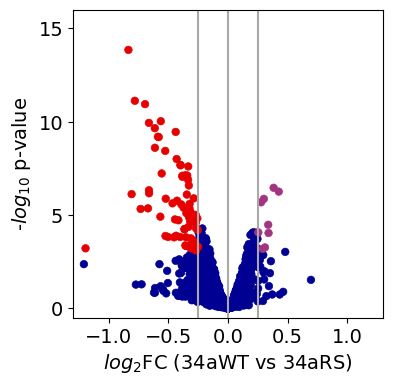

  Diff exp WT-RS  count
0           None   1826
1           Down     78
2             Up      9 



<Figure size 400x400 with 0 Axes>

In [2]:
# Read data: genes with >=1 site
data = pd.read_csv(DGE_FILE, sep='\t')
sites = pd.read_csv(SITES_FILE, sep='\t')
sites.drop_duplicates(subset='Gene ID', inplace=True)
data = pd.merge(data, sites['Gene ID'])
# Keep genes significantly downregulated by 34aWT
data = data[(data['log2fc WT-NC'] < 0) & (data['FDR WT-NC'] < 0.05)]

x_var = 'log2fc WT-RS'
y_var = '-log10 pval WT-RS'
hue = 'Diff exp WT-RS'
groups = ['None', 'Down', 'Up']

data[y_var] = -np.log10(data['pval WT-RS'])
data[hue] = data.apply(
    lambda x: 'Up' if x['FDR WT-RS'] < 0.05 and x[x_var] > 0.25
    else 'Down' if x['FDR WT-RS'] < 0.05 and x[x_var] < -0.25
    else 'None', axis=1)

plot.scatter(
    data, x=x_var, y=y_var, hue=hue, hue_order=groups, palette=VOLCANO_PALETTE,
    xlim=(-1.3, 1.3), ylim=(-0.5, 16), xticks=(-1, 1, 0.5), yticks=(0, 15, 5),
    xlabel='$log_{2}$FC (34aWT vs 34aRS)', ylabel='-$log_{10}$ p-value',
    size=30, vlines=[-0.25, 0, 0.25], outfile=FIG_DIR+'4A')  

counts = data[hue].value_counts().reset_index()
counts.sort_values(hue, key=np.vectorize(groups.index), inplace=True)
print(counts, '\n')

## FIG. 4B

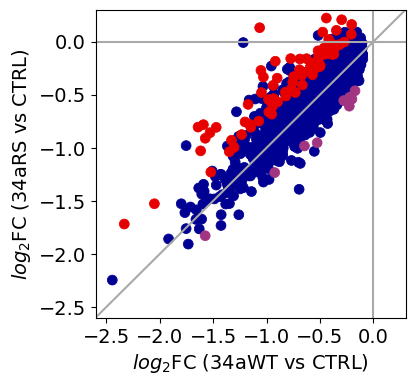

<Figure size 400x400 with 0 Axes>

In [3]:
# Read data: genes with >=1 site
data = pd.read_csv(DGE_FILE, sep='\t')
sites = pd.read_csv(SITES_FILE, sep='\t')
sites.drop_duplicates(subset='Gene ID', inplace=True)
data = pd.merge(data, sites['Gene ID'])
# Keep genes significantly downregulated by 34aWT
data = data[(data['log2fc WT-NC'] < 0) & (data['FDR WT-NC'] < 0.05)]

x_var = 'log2fc WT-NC'
y_var = 'log2fc RS-NC'
hue = 'Diff exp WT-RS'
groups = ['None', 'Down', 'Up']

data[hue] = data.apply(
    lambda x: 'Up' if x['FDR WT-RS'] < 0.05 and x['log2fc WT-RS'] > 0.25
    else 'Down' if x['FDR WT-RS'] < 0.05 and x['log2fc WT-RS'] < -0.25
    else 'None', axis=1)

plot.scatter(
    data, x=x_var, y=y_var, hue=hue, hue_order=groups,
    palette=VOLCANO_PALETTE, size=50, diagonal=True, vlines=[0], hlines=[0],
    xlim=(-2.6, 0.3), ylim=(-2.6, 0.3), xticks=(-2.5, 0, 0.5), yticks=(-2.5, 0, 0.5),
    xlabel='$log_{2}$FC (34aWT vs CTRL)', ylabel='$log_{2}$FC (34aRS vs CTRL)',
    outfile=FIG_DIR+'4B')

## Structure prediction

In [4]:
# Read data: genes with >=1 site
data = pd.read_csv(DGE_FILE, sep='\t')
sites = pd.read_csv(SITES_FILE, sep='\t')
data = pd.merge(data, sites)
# Keep genes significantly downregulated by 34aWT
data = data[(data['log2fc WT-NC'] < 0) & (data['FDR WT-NC'] < 0.05)]
# Genes downregulated by WT compared to RS
data = data[(data['log2fc WT-RS'] < -0.25) & (data['FDR WT-RS'] < 0.05)]

constraints = Constraints(
    force_paired=({13}, {14},),
    min_pairs=3, offset=(-4, 4), no_gu=True, max_mm_count=0)
columns = ['3P start', 'Target pairs', 'miRNA pairs', 'MFE',
           'Offset', 'GU pairs']
data[columns] = data.progress_apply(
    get_top_structure, args=(STRUCT_DIR, constraints,), axis=1)

print(data.dropna(subset='3P start').shape[0], '/', data.shape[0], 'sites')
print(data.dropna(subset='3P start')['Gene ID'].nunique(),
      '/', data['Gene ID'].nunique(), 'genes')

data.dropna(subset='3P start', inplace=True)

  0%|          | 0/144 [00:00<?, ?it/s]

81 / 144 sites
61 / 78 genes


## FIG. 4C

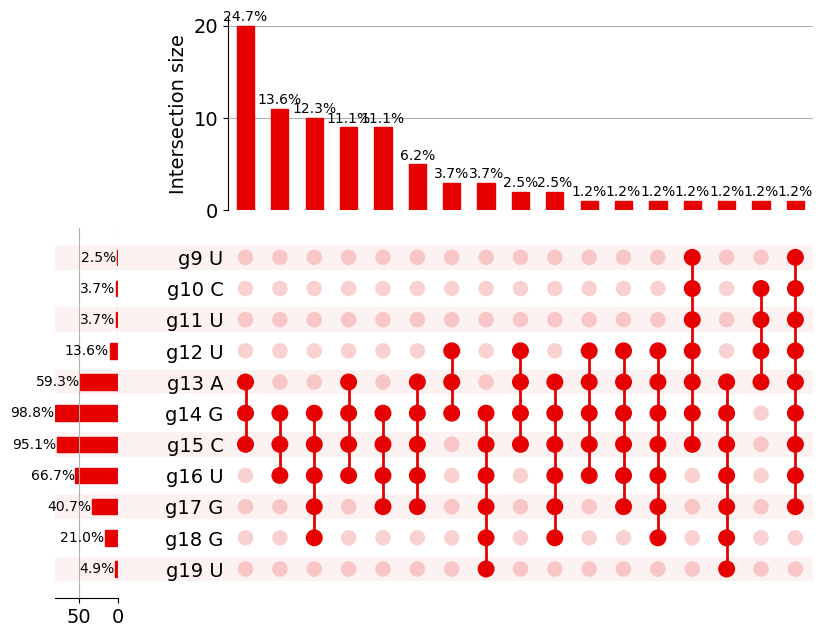

In [5]:
mir_seq = [str(mir.seq) for mir in
           list(SeqIO.parse(MIR_SEQ_FILE, 'fasta'))][0]

sites = data[['Gene ID', 'Seed start', 'miRNA pairs']].values.tolist()
bases = list(range(13, 17, 1))
bases = list(range(9, 20, 1))
gene_subsets = []
for base in bases:
    matches = []
    for gene_id, seed_start, mir_paired in sites:
        if base in mir_paired:
            matches.append(gene_id+'_'+str(seed_start))
    gene_subsets.append(matches)

bases = ['g'+str(base)+' '+mir_seq[base-1] for base in bases]
subsets = {i: j for i, j in zip(*[bases, gene_subsets])}
subsets = from_contents(subsets)

ax_dict = UpSet(
    subsets, sort_by='cardinality', sort_categories_by='-input',
    show_percentages=True, facecolor='#e60000').plot()
plt.savefig(FIG_DIR+'4C', dpi=600)

## FIG. 4D

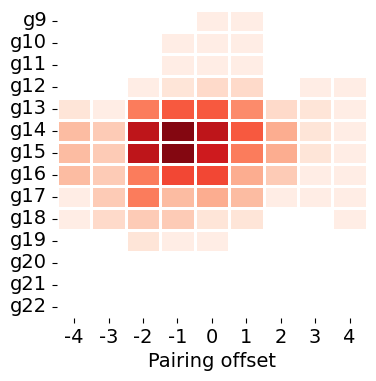

<Figure size 400x400 with 0 Axes>

In [6]:
site_count = data.shape[0]
data = data.explode(column=['miRNA pairs'])
data = data[['Offset', 'miRNA pairs']]
data = data.groupby('Offset', as_index=False).value_counts()

bases = list(range(9, 23, 1))
offsets = list(range(-4, 5, 1))

matrix = np.zeros((len(bases), len(offsets)))
for i, base in enumerate(bases):
    for j, offset in enumerate(offsets):
        count = data[(data['miRNA pairs'] == base) &
                     (data['Offset'] == offset)]['count'].tolist()
        if count:
            matrix[i, j] = count[0]
matrix = matrix/site_count
matrix = np.where(matrix == 0., np.nan, matrix)

plot.heatmap(
    matrix, vmin=0, vmax=0.25, cmap='Reds', cbar=False,
    xticklabels=offsets, yticklabels=['g'+str(i) for i in bases],
    xlabel='Pairing offset', outfile=FIG_DIR+'4D')